In [2]:
import datetime as datetime  
import numpy as np
import seaborn as sns
import pandas as pd  
import statsmodels.api as sm  
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os
% matplotlib inline
sns.set_context('poster')

In [3]:
def load_encoders():
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()
    
    src_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    dst_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    type_encoder.classes_ = np.load('encoders/type.npy')
    activity_encoder.classes_ = np.load('encoders/activity.npy')
    protocol_encoder.classes_ = np.load('encoders/protocol.npy')
    t_endpoint_encoder.classes_ = np.load('encoders/endpoint.npy')
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def train_encoders(rucio_data, use_cache=True):
    
    if use_cache:
        if os.path.isfile('encoders/ddm_rse_endpoints.npy') and os.path.isfile('encoders/activity.npy'):
            print('using cached LabelEncoders for encoding data.....')
            src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder=load_encoders()
        else:
            print('NO cache found')
    else:
        print('No cached encoders found ! Training Some New Ones using input data!')
        src_encoder = LabelEncoder()
        dst_encoder = LabelEncoder()
        type_encoder = LabelEncoder()
        activity_encoder = LabelEncoder()
        protocol_encoder = LabelEncoder()
        t_endpoint_encoder = LabelEncoder()

        src_encoder.fit(rucio_data['src-rse'].unique())
        dst_encoder.fit(rucio_data['dst-rse'].unique())
        type_encoder.fit(rucio_data['src-type'].unique())
        activity_encoder.fit(rucio_data['activity'].unique())
        protocol_encoder.fit(rucio_data['protocol'].unique())
        t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

        np.save('encoders/src.npy', src_encoder.classes_)
        np.save('encoders/dst.npy', dst_encoder.classes_)
        np.save('encoders/type.npy', type_encoder.classes_)
        np.save('encoders/activity.npy', activity_encoder.classes_)
        np.save('encoders/protocol.npy', protocol_encoder.classes_)
        np.save('encoders/endpoint.npy', t_endpoint_encoder.classes_)
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def preprocess_data(rucio_data, use_cache=True):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','name','previous-request-id','scope','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT, add dataetime index
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')
    
    # Reindex data with 'submittedd at timestamp'
    rucio_data.index = pd.DatetimeIndex(rucio_data['submitted_at'])
    
    #remove all timestamp columns
    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    # encode categorical data
 
    if use_cache==True:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=True)
    else:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=False)

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data

def rescale_data(rucio_data):
    
    # Normalization
    
    byte_scaler = MinMaxScaler(feature_range=(0, 1))
    delay_scaler = MinMaxScaler(feature_range=(0, 1))
    duration_scaler = MinMaxScaler(feature_range=(0, 1))
    
    byte_scaler = byte_scaler.fit(rucio_data['bytes'])
    delay_scaler = delay_scaler.fit(rucio_data['delay'])
    duration_scaler = duration_scaler.fit(rucio_data['duration'])
    
    rucio_data['bytes'] = byte_scaler.transform(rucio_data['bytes'])
    rucio_data['delay'] = delay_scaler.transform(rucio_data['delay'])
    rucio_data['duration'] = duration_scaler.transform(rucio_data['duration'])
    
    return rucio_data, byte_scaler, delay_scaler, duration_scaler
    
    
def split_data(rucio_data,durations, num_timesteps=50, split_frac=0.9):
    
#     slice_size = batch_size*num_timesteps
    print(rucio_data.shape[0])
    n_examples = rucio_data.shape[0]
    n_batches = (n_examples - num_timesteps )
    print('Total Batches : {}'.format(n_batches))
    
    inputs=[]
    outputs=[]
    for i in range(0,n_batches):
        v = rucio_data[i:i+num_timesteps]
        w = durations[i+num_timesteps]
        inputs.append(v)
        outputs.append(w)
    
    inputs = np.stack(inputs)
    outputs = np.stack(outputs)
    print(inputs.shape, outputs.shape)
    
    split_idx = int(inputs.shape[0]*split_frac)
    trainX, trainY = inputs[:split_idx], outputs[:split_idx]
    testX, testY = inputs[split_idx:], outputs[split_idx:]
    print('Training Data shape:',trainX.shape, trainY.shape)
    print('Test Data shape: ',testX.shape, testY.shape)
    return trainX, trainY, testX, testY

def plot_graphs_and_rescale(data):
    
    durations = data['duration']
    durations.plot()
    plt.ylabel('durations(seconds)')
    plt.show()

    filesize = data['bytes']
    filesize.plot(label='filesize(bytes)')
    plt.ylabel('bytes')
    plt.show()

    delays = data['delay']
    delays.plot(label='delay(seconds)')
    plt.ylabel('delay')
    plt.show()
    
    print('rescaling input continuous variables : filesizes, queue-times, transfer-durations')
    data, byte_scaler, delay_scaler, duration_scaler = rescale_data(data)

    plt.plot(data['bytes'], 'r', label='filesize')
    plt.plot(data['duration'], 'y', label='durations')
    plt.plot(data['delay'],'g', label='queue-time')
    plt.legend()
    plt.xticks(rotation=20)
    plt.show()
    
    return data, byte_scaler, delay_scaler, duration_scaler
# def 
# get_and_preprocess_data():
    

In [4]:
path = '../' # Change this as you need.

def plot_rucio(path='../'):
    abspaths = []
    for fn in os.listdir(path):
        if 'atlas_rucio' in fn:
            abspaths.append(os.path.abspath(os.path.join(path, fn)))
    print("\n".join(abspaths))
    
    for path in abspaths:
        print('reading : ',path)
        data = pd.read_csv(path)
        print('shape :', data.shape)
        data  = preprocess_data(data)
        data, byte_scaler, delay_scaler, duration_scaler = plot_graphs_and_rescale(data)


/eos/user/v/vysharma/data/atlas_rucio-events-2017.07.06.csv
/eos/user/v/vysharma/data/atlas_rucio-events-2017.07.12.csv
/eos/user/v/vysharma/data/atlas_rucio-events-2017.07.13.csv
/eos/user/v/vysharma/data/atlas_rucio-events-2017.07.16.csv
/eos/user/v/vysharma/data/atlas_rucio-events-2017.07.19.csv
reading :  /eos/user/v/vysharma/data/atlas_rucio-events-2017.07.06.csv
shape : (313565, 27)
using cached LabelEncoders for encoding data.....


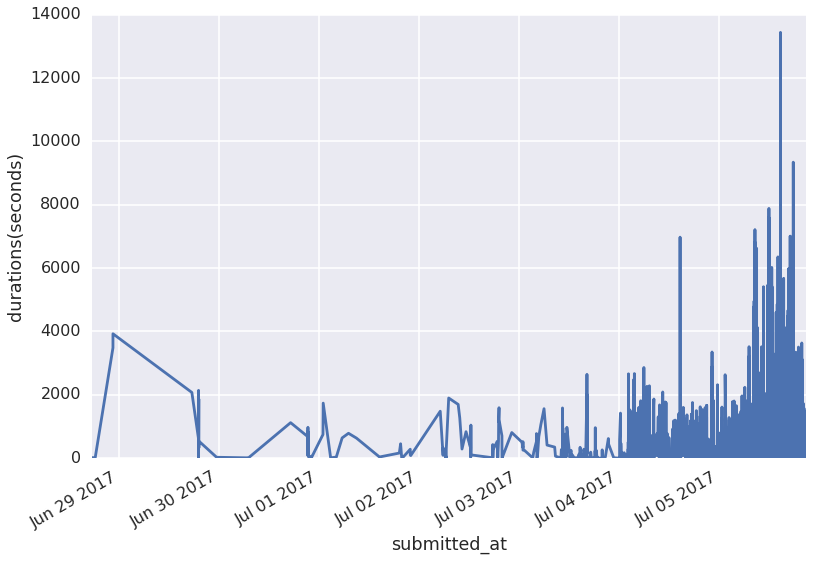

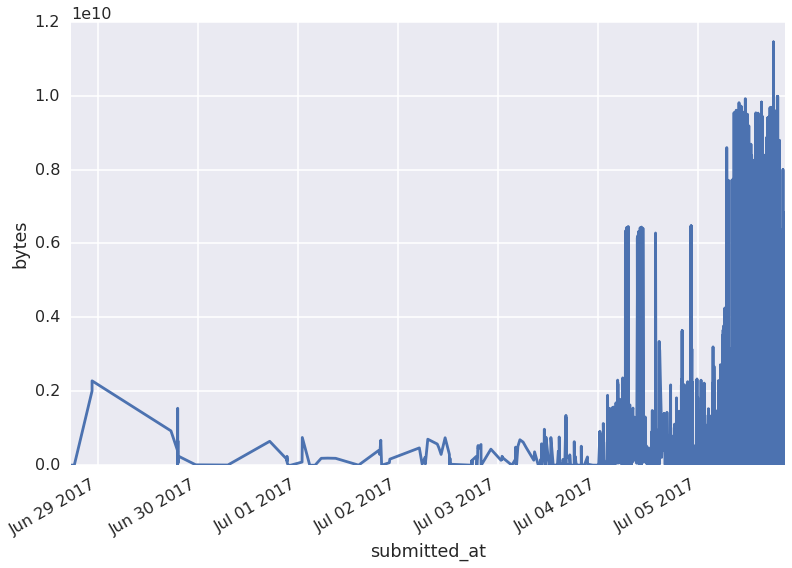

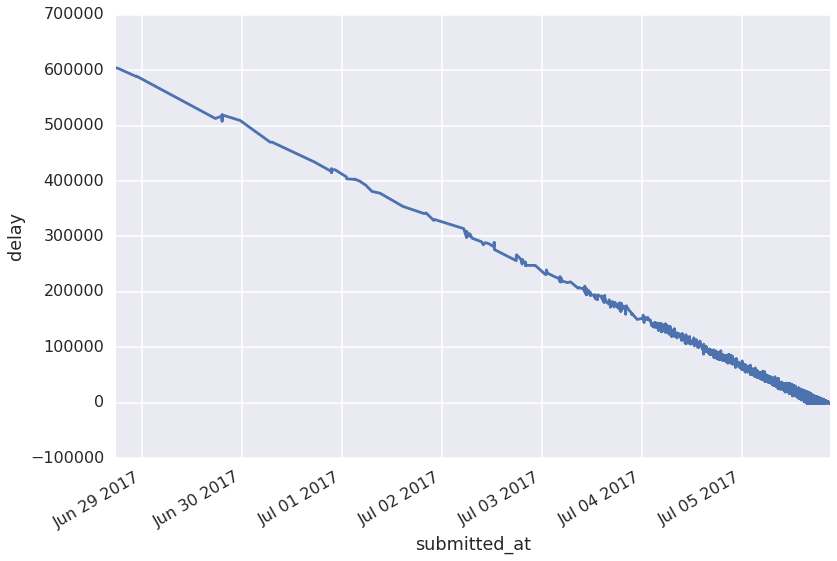

rescaling input continuous variables : filesizes, queue-times, transfer-durations


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

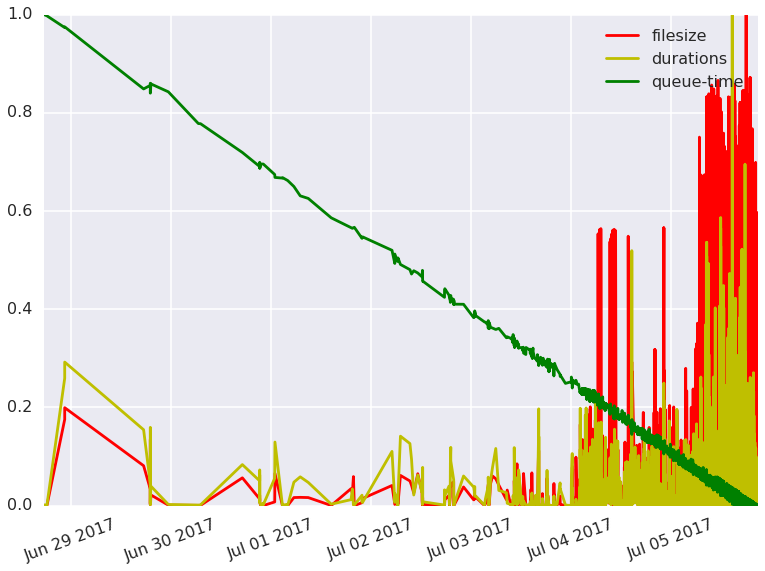

reading :  /eos/user/v/vysharma/data/atlas_rucio-events-2017.07.12.csv
shape : (2930000, 27)
using cached LabelEncoders for encoding data.....


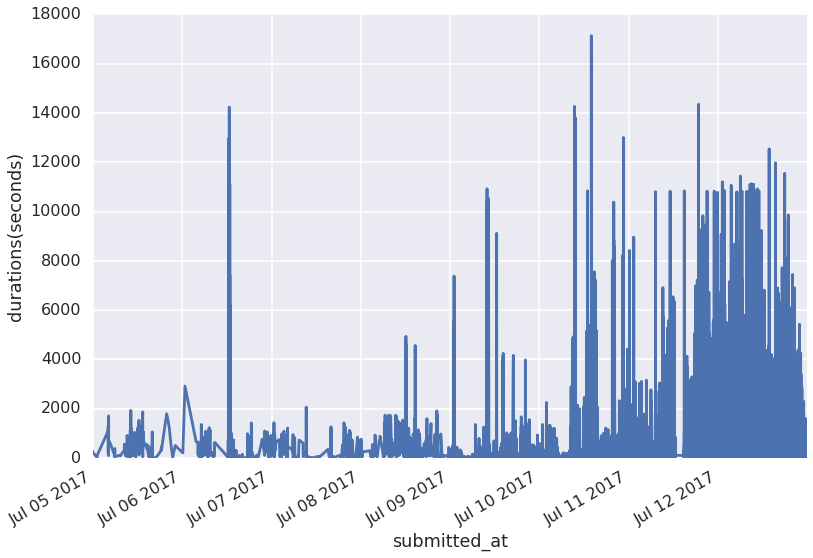

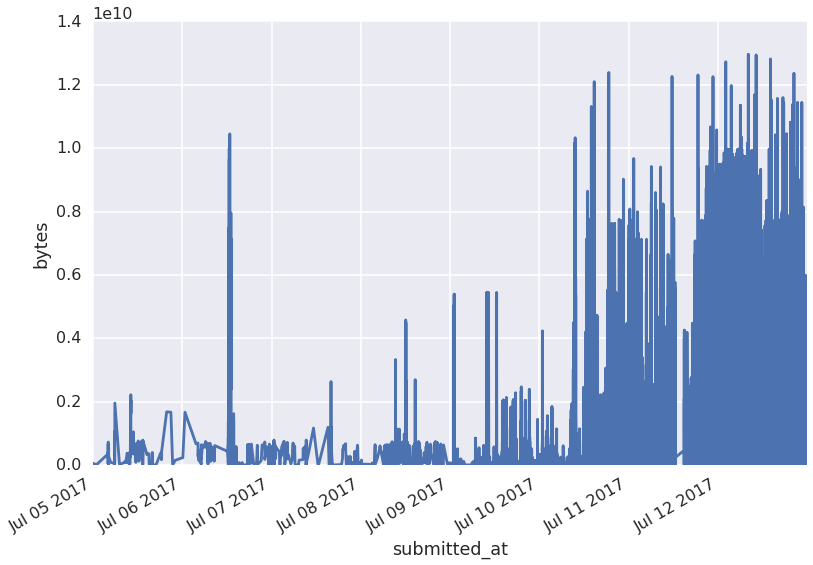

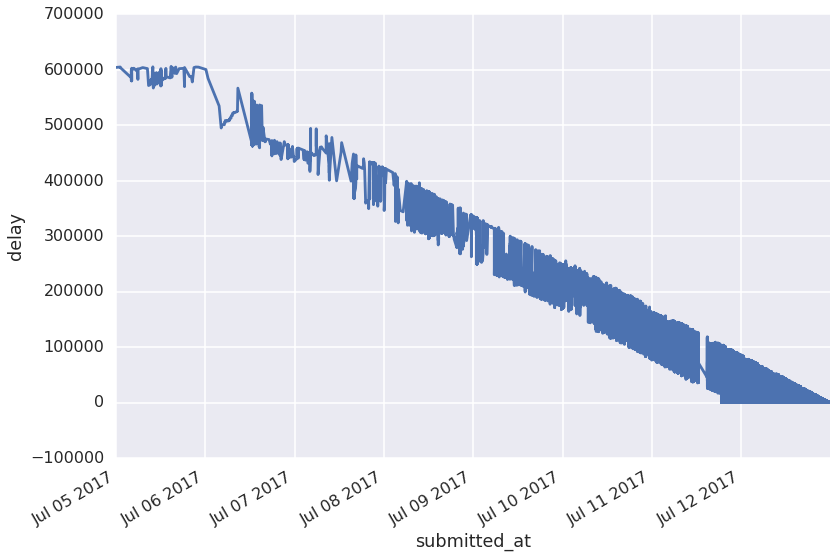

rescaling input continuous variables : filesizes, queue-times, transfer-durations


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

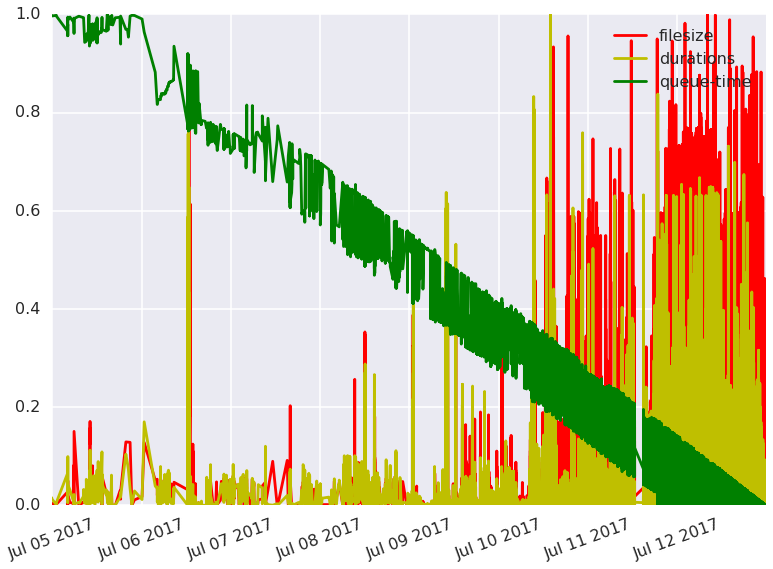

reading :  /eos/user/v/vysharma/data/atlas_rucio-events-2017.07.13.csv
shape : (1717044, 27)
using cached LabelEncoders for encoding data.....


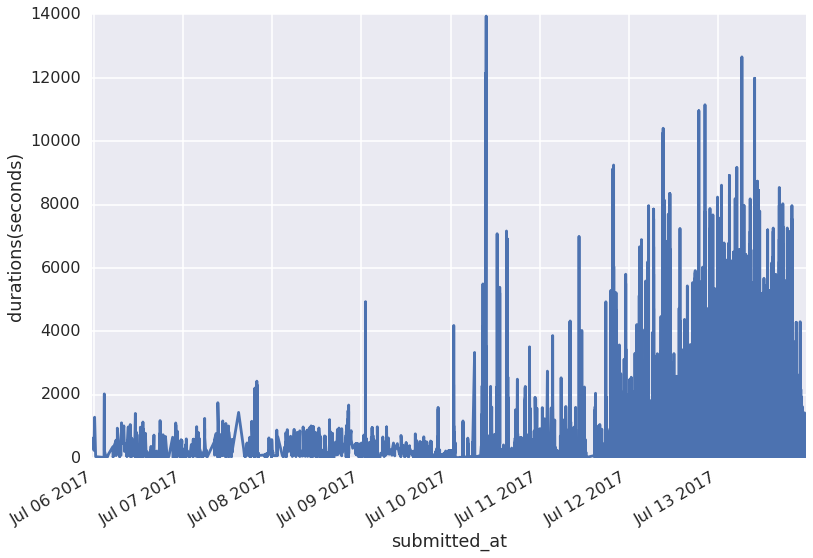

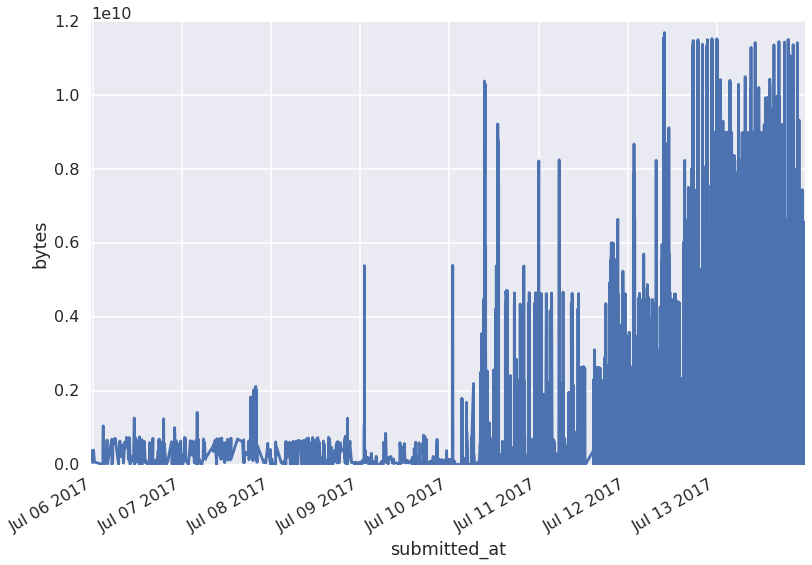

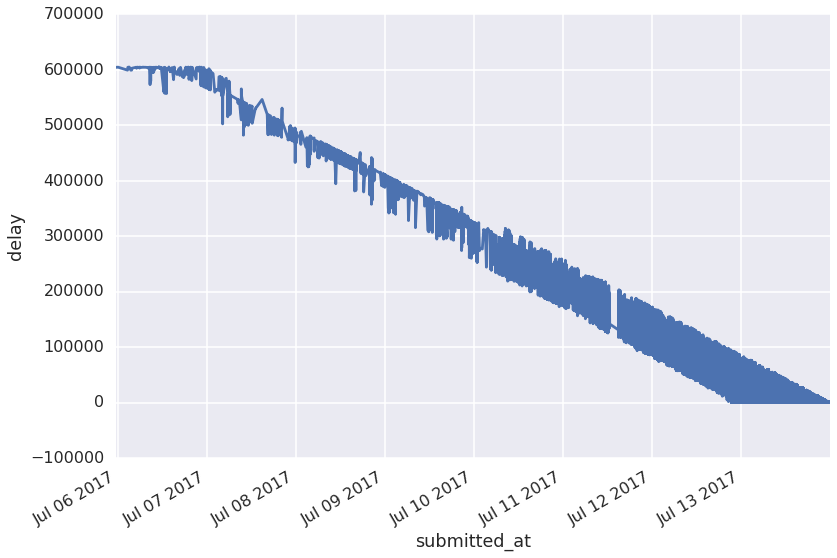

rescaling input continuous variables : filesizes, queue-times, transfer-durations


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

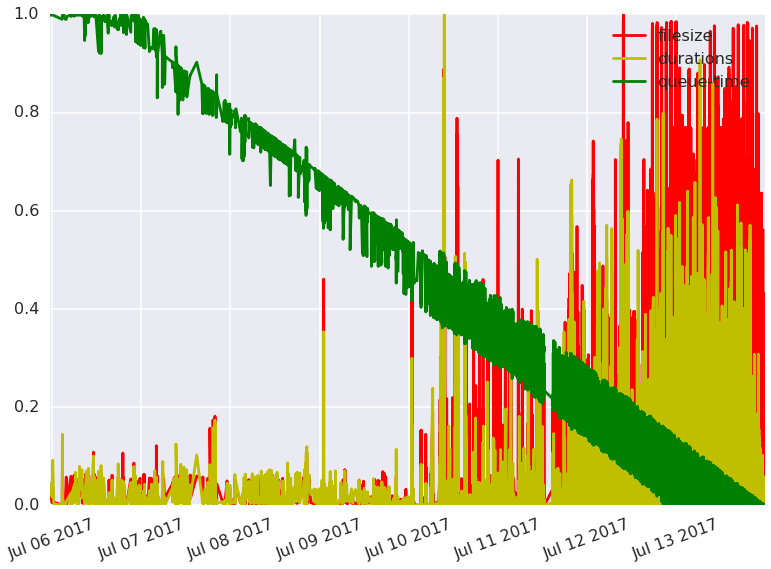

reading :  /eos/user/v/vysharma/data/atlas_rucio-events-2017.07.16.csv
shape : (1425252, 27)
using cached LabelEncoders for encoding data.....


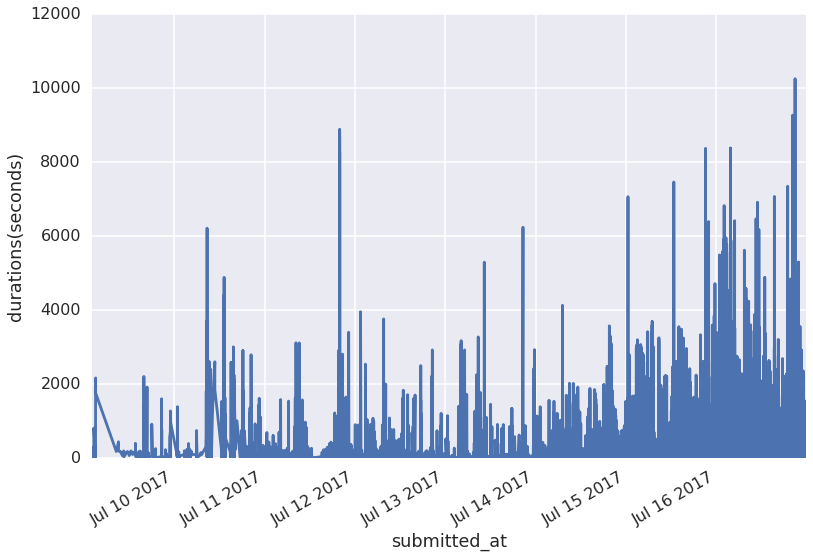

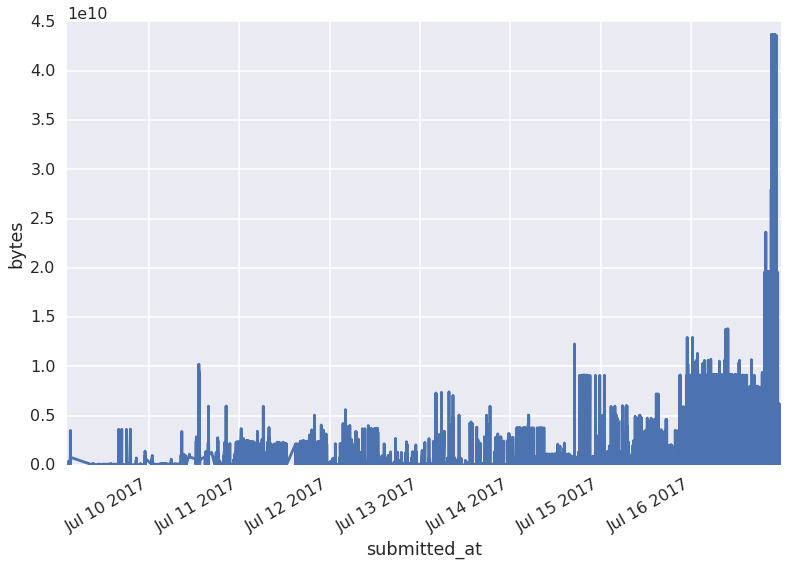

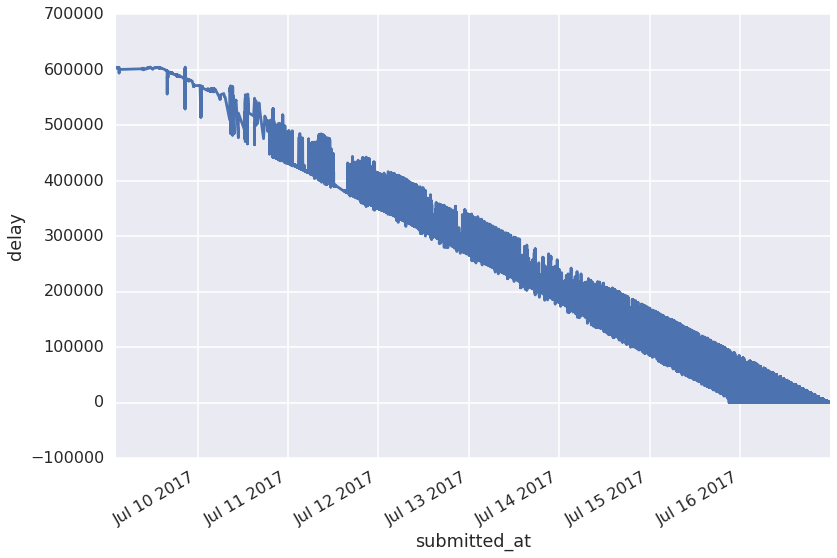

rescaling input continuous variables : filesizes, queue-times, transfer-durations


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

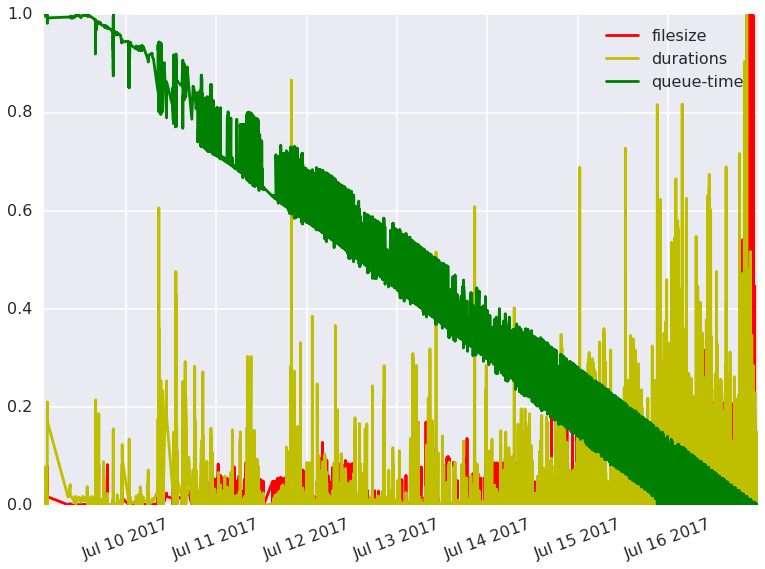

reading :  /eos/user/v/vysharma/data/atlas_rucio-events-2017.07.19.csv
shape : (1955596, 27)
using cached LabelEncoders for encoding data.....


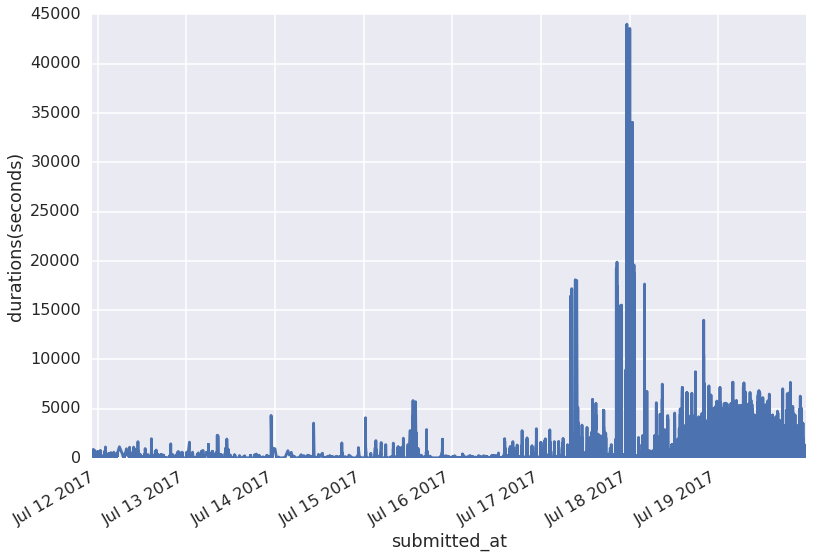

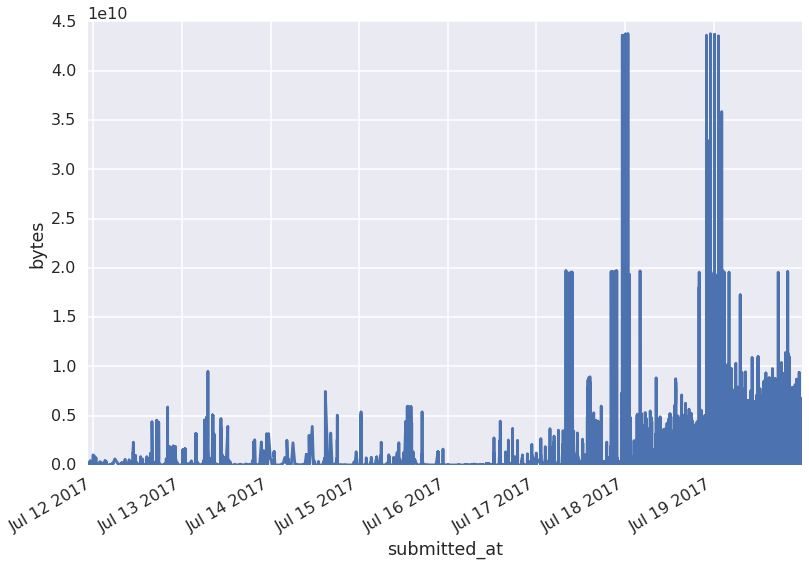

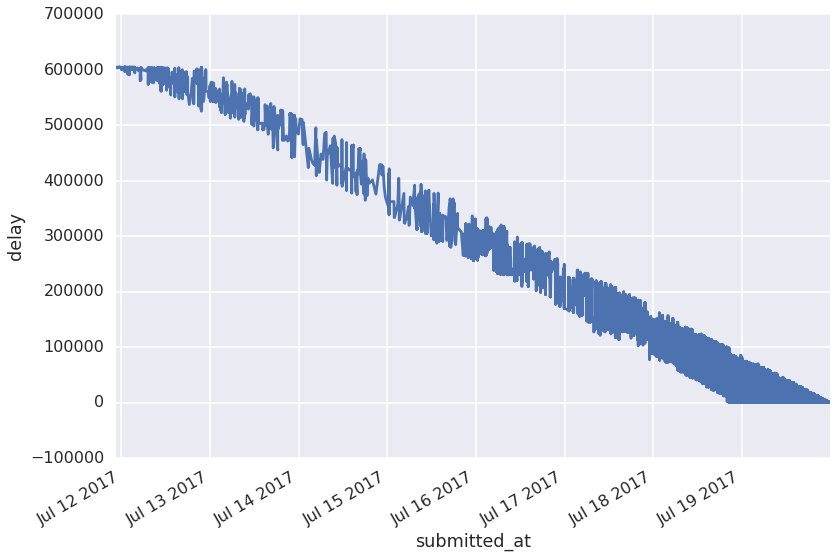

rescaling input continuous variables : filesizes, queue-times, transfer-durations


/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

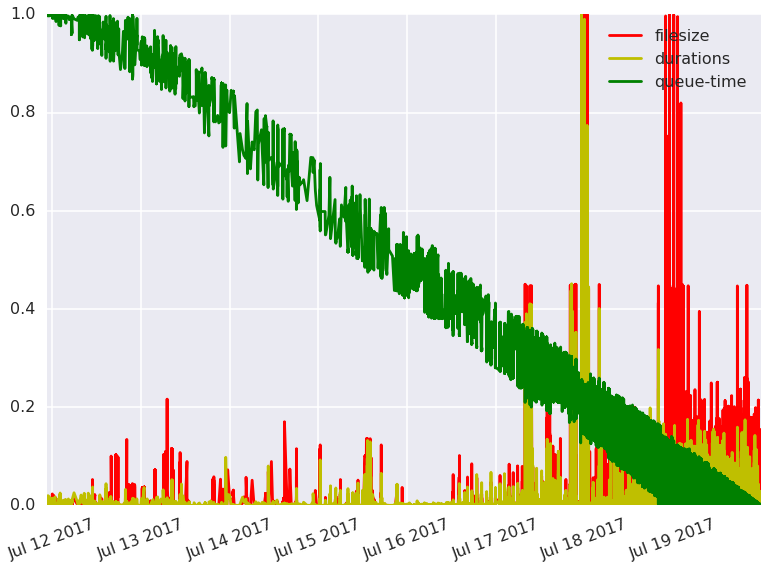

In [5]:
plot_rucio(path='../data/')

In [28]:
data.shape

(2085203, 10)

In [29]:
data.head()

,activity,bytes,dst-rse,dst-type,duration,protocol,src-rse,src-type,transfer-endpoint,delay
submitted_at,,,,,,,,,,
2017-06-14 00:59:55,1,2.185302e-02,482,0,0.005138,2,310,0,0,0.994136
2017-06-14 03:35:27,1,7.828251e-02,526,0,0.008849,2,310,0,0,0.998567
2017-06-14 04:25:07,1,6.519615e-03,526,0,0.000999,2,310,0,0,0.996835
2017-06-14 06:17:14,1,5.891379e-02,526,0,0.009919,2,310,0,0,0.997889
2017-06-14 08:36:38,11,1.470533e-08,533,0,0.000428,2,325,0,0,0.983981


# Applying Seasonal Trend Decomposition

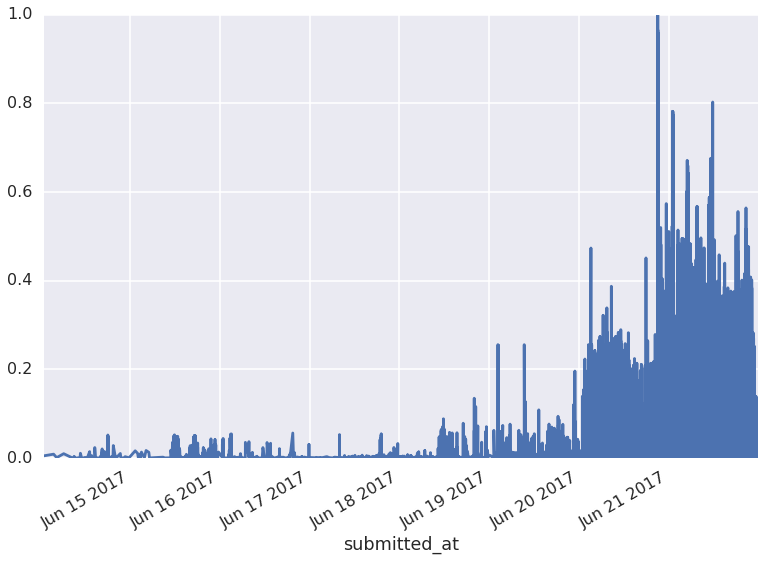

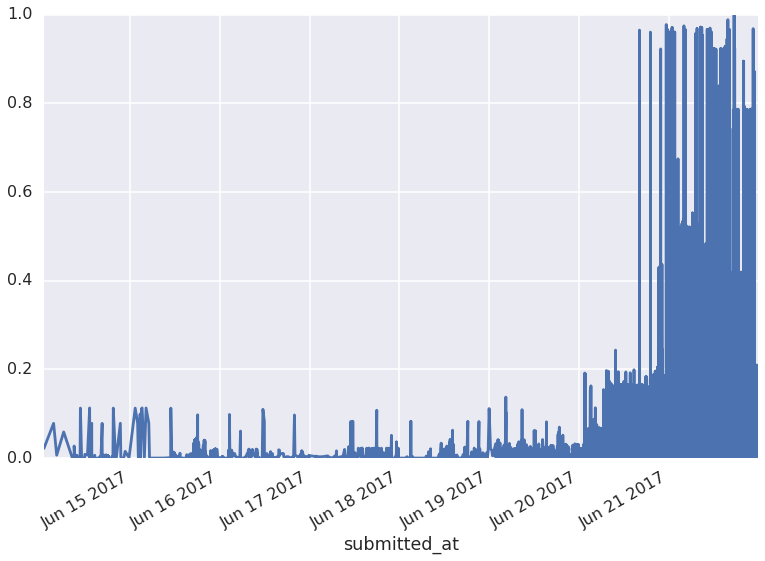

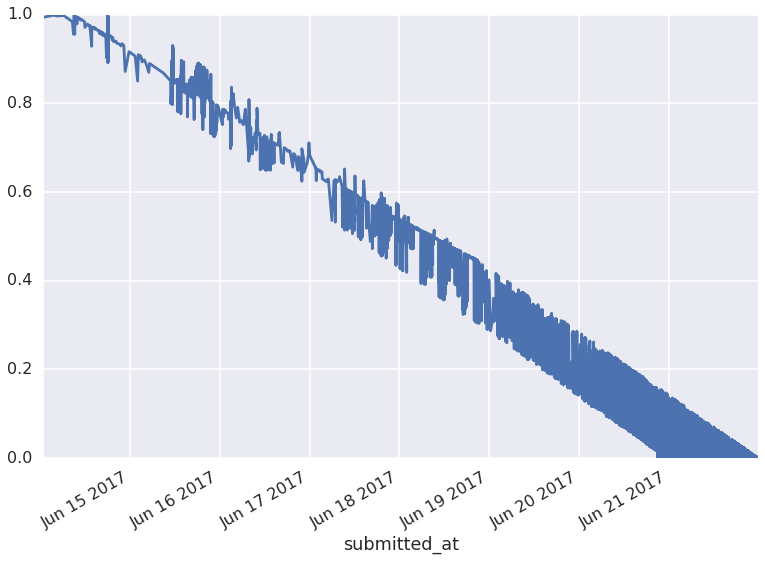

In [50]:
duration = data['duration']
filesizes = data['bytes']
queue_times = data['delay']

duration.plot()
plt.show()

filesizes.plot()
plt.show()

queue_times.plot()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


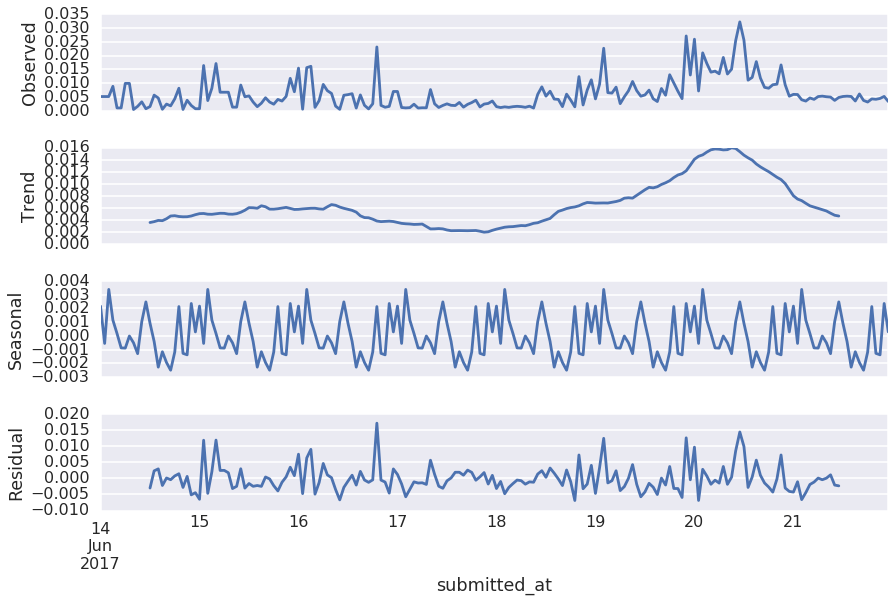

In [51]:
# resampling data by the Hour
duration_per_min = duration.resample('H', how='mean').ffill()

res = sm.tsa.seasonal_decompose(duration_per_min)  
res.plot()
plt.show()

# duration.head()

/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


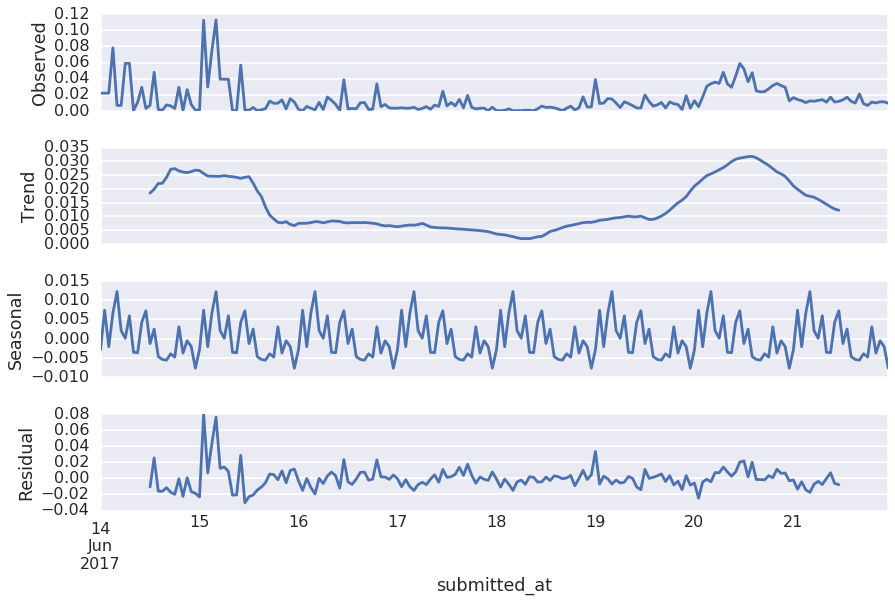

In [52]:
filesizes_per_hour = filesizes.resample('H', how='mean').ffill()

res = sm.tsa.seasonal_decompose(filesizes_per_hour)  
res.plot()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_88Py3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


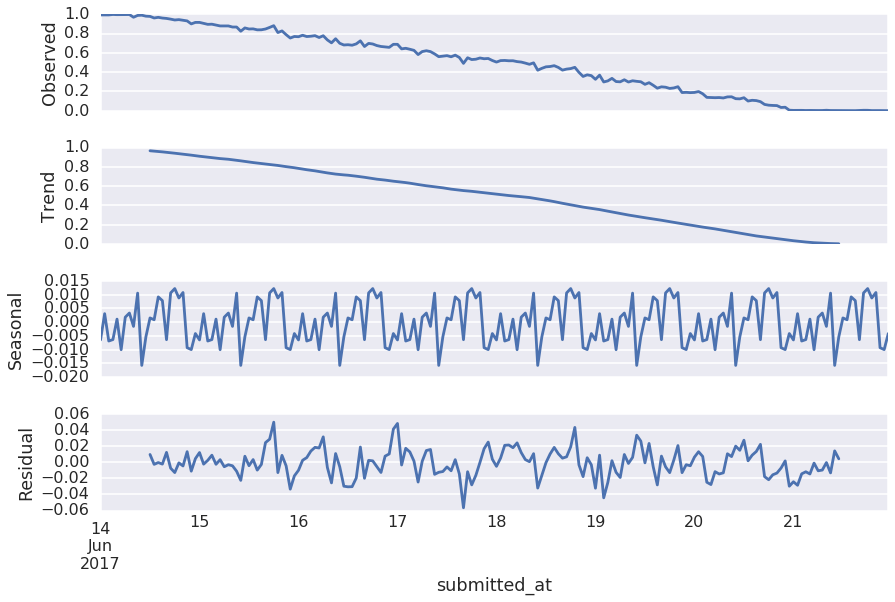

In [54]:
delay_per_hour = queue_times.resample('H', how='mean').ffill()

res = sm.tsa.seasonal_decompose(delay_per_hour)  
res.plot()
plt.show()